In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import eleanor
import lightkurve as lk
from scipy.optimize import minimize
from astropy.wcs import WCS

In [4]:
star = eleanor.Source(tic=120362128, sector=14, tc=True)

In [24]:
star.premade = False
sc = lk.search_targetpixelfile(target='tic120362128', sector=14).download()
sq = sc.quality < 5000
start = 2500
end = 3400
time = sc.time[sq][start:end].value
tpfs = sc.flux[sq][start:end].value
errs = sc.flux_err[sq][start:end].value
bkgs = sc.flux_bkg[sq,0,0][start:end].value
bkg0 = np.mean(bkgs)
data = eleanor.TargetData(
    star, 
    height=13, 
    width=13, 
    do_pca=True, 
    do_psf=False,
    time_arr=time, 
    data_arr=tpfs, 
    err_arr=errs, 
    bkg_arr=bkgs, 
)
photometry_flux = sc.to_lightcurve().flux[sq][start:end]

In [20]:
prf = eleanor.prf.make_prf_from_source(star)

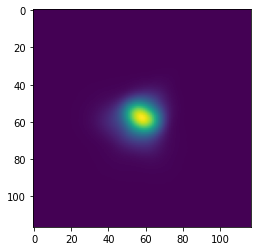

In [55]:
plt.imshow(prf)

In [57]:
gaussian_model = eleanor.models.Gaussian(
            shape=(117, 117), 
            col_ref=0, 
            row_ref=0, 
            xc = [59],
            yc = [59],
            fit_idx = 2,
            bkg0 = bkgs[0]
        )

In [63]:
model = gaussian_model
p = np.concatenate(([0, 0], model.get_default_optpars()))
def loss(pars):
    if abs(pars[0]) > 2 or abs(pars[1]) > 2:
        return np.inf
    return np.sum((prf - model.evaluate(1, pars[0], pars[1], pars[2:]))**2)

res = minimize(loss, p)

In [64]:
res

      fun: nan
 hess_inv: array([[ 2.27230348,  1.27233776, -1.16568838, -0.75470029, -1.16571742],
       [ 1.27233776,  2.27237205, -1.16571625, -0.75471842, -1.16574529],
       [-1.16568838, -1.16571625,  1.99352116,  0.64210232,  0.99354443],
       [-0.75470029, -0.75471842,  0.64210232,  1.41389874,  0.64211741],
       [-1.16571742, -1.16574529,  0.99354443,  0.64211741,  1.99356769]])
      jac: array([nan, nan, nan, nan, nan])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 684
      nit: 3
     njev: 114
   status: 2
  success: False
        x: array([ 413.78977383,  413.80162148, -395.2688189 , -257.68945845,
       -395.27897029])

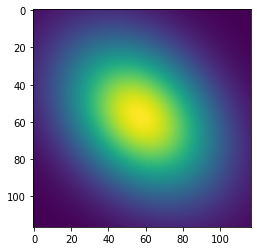

In [65]:
plt.imshow(model.evaluate(30, res.x[0], res.x[1], 0.001 * np.array([0.6872276 , -0.20908673,  0.68722326])))

In [16]:
data.psf_lightcurve(flux_arr=photometry_flux.value, model_name='Gaussian', bkg_mag_cutoff=10, verbose=True)

100%|██████████| 900/900 [02:58<00:00,  5.04it/s]
193446371001.04636
193446371001.04636
193446371001.04636
193446371001.04636
193446371001.04636
193446371001.04636
193446371001.04636
193446371001.04636


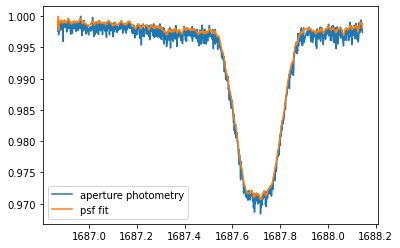

In [17]:
plt.plot(time, photometry_flux / np.max(photometry_flux), label='aperture photometry')
plt.plot(time, data.psf_flux[:end-start] / np.max(data.psf_flux[:end-start]), label='psf fit')
plt.legend()
plt.show()

In [18]:
data.psf_params

array([-0.03284687, -0.01958083,  0.67704575, -0.00439924,  0.73247635])

In [19]:
data.arma_res

     fun: 193446371001.04636
     jac: array([0., 0., 0., 0., 0., 0., 0.])
 message: 'Local minimum reached (|pg| ~= 0)'
    nfev: 8
     nit: 0
  status: 0
 success: True
       x: array([1., 1., 1., 1., 1., 1., 1.])

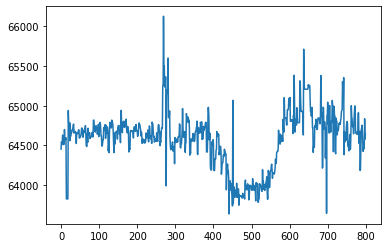

In [32]:
plt.plot(data.naive_psf_flux[2,100:])

In [115]:
gaussian_model = eleanor.models.Gaussian(
            shape=tpfs.shape[1:], 
            col_ref=0, 
            row_ref=0, 
            xc = [4.51646021, 4.3177313, 4.10392764],
            yc = [6.52438976, 2.51141035, 3.87952034],
            fit_idx = 2,
            bkg0 = bkgs[0]
        )

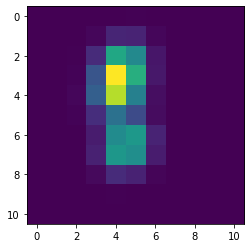

In [116]:
plt.imshow(gaussian_model.mean(np.max(tpfs[0]) * np.ones(3,), 0, 0, bkg0, [0.9, 0.1, 0.8]))

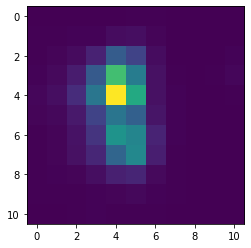

In [117]:
plt.imshow(tpfs[0])

In [120]:
model_tpf0 = gaussian_model.mean(np.max(tpfs[0]) * np.ones(3,), 0, 0, bkg0, [0.9, 0.1, 0.8])

In [171]:
from functools import reduce

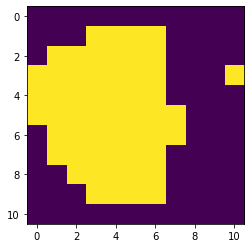

In [174]:
plt.imshow(reduce(np.bitwise_or, np.array([b < d for (b, d) in zip(bkgs, tpfs)])))